# Лабораторная работа №8 (Проведение исследований моделями обнаружения и распознавания объектов)

## 1. Выбор начальных условий

### 1.a Выбор набора данных

Для данной лабораторной работы выбран **синтетический набор данных**, содержащий изображения с простыми геометрическими фигурами: квадратами и кругами. Каждое изображение содержит от 0 до нескольких объектов одного или обоих классов. Аннотации предоставляются в формате YOLO (класс, центр_x, центр_y, ширина, высота).

**Обоснование выбора:**
* **Практическая задача**: Даже такой синтетический набор данных может быть полезен, например контроль качества на производственной линии, где необходимо обнаружить и классифицировать простые компоненты (например, болты и шайбы) на однотонном конвейере.
*   **Простота:** Синтетический датасет позволяет полностью контролировать сложность изображений, количество классов и объектов, что упрощает отладку и понимание работы моделей детекции.
*   **Скорость генерации:** Генерация данных происходит быстро, не требуя загрузки и обработки больших архивов.
*   **Четкие аннотации:** Отсутствие ошибок в аннотациях, характерных для реальных датасетов.
*   **Фокус на алгоритмах:** Позволяет сосредоточиться на сравнении самих алгоритмов и техник улучшения, а не на особенностях конкретного реального датасета.

### 1.b Выбор метрик качества

Для оценки качества моделей обнаружения объектов будут использоваться следующие метрики:
*   **Mean Average Precision (mAP):** Среднее значение Average Precision (AP) по всем классам и при различных порогах Intersection over Union (IoU). Это стандартная метрика для оценки детекции объектов, учитывающая как точность локализации (через IoU), так и точность классификации и уверенность модели (через Precision-Recall кривую).
    
    Будем использовать **mAP@0.5**: mAP, рассчитанный при пороге IoU равным 0.5. Это распространенная метрика для оценки общей производительности модели.

**Обоснование выбора:**
*   **mAP:** Комплексная метрика, отражающая способность модели правильно определять как местоположение (bounding box), так и класс объектов, а также ее уверенность в предсказаниях. Это общепринятая метрика в задачах детекции объектов, позволяющая корректно сравнивать различные модели и подходы.
*   **mAP@0.5:** Удобен для простых датасетов или задач, где требуется хорошее, но не идеальное совпадение предсказанных и истинных рамок.

## 2. Создание бейзлайна и оценка качества

Загрузка библиотек, если не установлено

In [1]:
%pip install ultralytics pillow numpy matplotlib torch torchvision ultralytics

Импорт библиотек

In [2]:
import os
import random
import shutil
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image, ImageDraw
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm

from ultralytics import YOLO

### 2.a Подготовка синтетического набора данных

In [3]:
DATA_DIR = "./synthetic_dataset"
IMAGE_SIZE = 256
CLASSES = ['square', 'circle']
NUM_CLASSES = len(CLASSES)
BASE_TRAIN_SAMPLES = 500
BASE_VAL_SAMPLES = 100

def create_synthetic_dataset(base_dir, num_samples, img_size, classes, max_objects=3, single_object_only=False):
    """Generates synthetic images with shapes and YOLO annotations."""
    img_dir = os.path.join(base_dir, 'images')
    lbl_dir = os.path.join(base_dir, 'labels')
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(lbl_dir, exist_ok=True)

    class_map = {name: i for i, name in enumerate(classes)}

    for i in tqdm(range(num_samples), desc=f"Generating {base_dir.split('/')[-1]} data"):
        img = Image.new('RGB', (img_size, img_size), color='white')
        draw = ImageDraw.Draw(img)
        annotation_lines = []

        num_objects = 1 # Always at least one object if not single_object_only and max_objects > 0
        if max_objects > 0 and not single_object_only:
             num_objects = random.randint(0, max_objects) if max_objects > 1 else 1
        elif single_object_only and max_objects > 0:
             num_objects = 1 # Strictly one object
        elif max_objects == 0:
            num_objects = 0


        for _ in range(num_objects):
            cls_name = random.choice(classes)
            cls_id = class_map[cls_name]

            # Simple logic to prevent drawing too small or too large objects or outside bounds
            size = random.randint(img_size // 10, img_size // 4)
            x_center = random.randint(size, img_size - size)
            y_center = random.randint(size, img_size - size)

            # Bbox in PIL format (x1, y1, x2, y2)
            x1 = x_center - size // 2
            y1 = y_center - size // 2
            x2 = x_center + size // 2
            y2 = y_center + size // 2

            if cls_name == 'square':
                draw.rectangle([(x1, y1), (x2, y2)], fill='red', outline='black')
            elif cls_name == 'circle':
                 # Ellipse takes (x1, y1, x2, y2) for the bounding box of the ellipse
                 draw.ellipse([(x1, y1), (x2, y2)], fill='blue', outline='black')

            # Convert bbox to YOLO format (center_x, center_y, width, height) normalized [0, 1]
            bbox_xc = x_center / img_size
            bbox_yc = y_center / img_size
            bbox_w = size / img_size
            bbox_h = size / img_size

            annotation_lines.append(f"{cls_id} {bbox_xc:.6f} {bbox_yc:.6f} {bbox_w:.6f} {bbox_h:.6f}")

        img_filename = f"image_{i:05d}.png"
        lbl_filename = f"image_{i:05d}.txt"
        img.save(os.path.join(img_dir, img_filename))
        with open(os.path.join(lbl_dir, lbl_filename), 'w') as f:
            f.write("\n".join(annotation_lines))

# Create directories for baseline data (multi-object possible)
base_train_dir = os.path.join(DATA_DIR, "baseline_train")
base_val_dir = os.path.join(DATA_DIR, "baseline_val")

create_synthetic_dataset(base_train_dir, BASE_TRAIN_SAMPLES, IMAGE_SIZE, CLASSES, max_objects=3)
create_synthetic_dataset(base_val_dir, BASE_VAL_SAMPLES, IMAGE_SIZE, CLASSES, max_objects=3)

Generating baseline_train data:   0%|          | 0/500 [00:00<?, ?it/s]

Generating baseline_val data:   0%|          | 0/100 [00:00<?, ?it/s]

Example Annotation:
['1 0.410156 0.488281 0.230469 0.230469\n', '0 0.136719 0.800781 0.097656 0.097656']


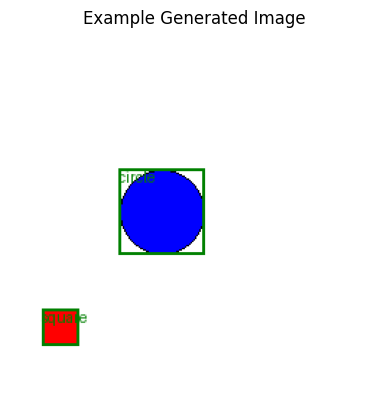

In [4]:
# Example: Display one generated image and its annotation
example_img_path = os.path.join(base_train_dir, "images", "image_00004.png")
example_lbl_path = os.path.join(base_train_dir, "labels", "image_00004.txt")

img = Image.open(example_img_path)
draw = ImageDraw.Draw(img)

print("Example Annotation:")
with open(example_lbl_path, 'r') as f:
    annotations = f.readlines()
    print(annotations)
    for line in annotations:
        cls_id, xc, yc, w, h = map(float, line.split())
        cls_name = CLASSES[int(cls_id)]

        # Convert YOLO to PIL (x1, y1, x2, y2)
        x1 = int((xc - w/2) * IMAGE_SIZE)
        y1 = int((yc - h/2) * IMAGE_SIZE)
        x2 = int((xc + w/2) * IMAGE_SIZE)
        y2 = int((yc + h/2) * IMAGE_SIZE)

        draw.rectangle([(x1, y1), (x2, y2)], outline='green', width=2)
        draw.text((x1, y1), cls_name, fill='green')

plt.imshow(img)
plt.title("Example Generated Image")
plt.axis('off')
plt.show()

In [5]:
# Create the dataset YAML file for Ultralytics
yaml_content = f"""
train: /content/synthetic_dataset/baseline_train/images
val: /content/synthetic_dataset/baseline_val/images

nc: {NUM_CLASSES}
names: {CLASSES}
"""

yaml_path = os.path.join(DATA_DIR, "baseline_dataset.yaml")
with open(yaml_path, "w") as f:
    f.write(yaml_content)

print(f"Dataset YAML saved to {yaml_path}")

Dataset YAML saved to ./synthetic_dataset/baseline_dataset.yaml


### 2.b Обучение базовой модели (Ultralytics YOLO)

Используем предобученную модель YOLO (например, `yolov8n.pt` как легкую опцию) и обучим ее на нашем синтетическом датасете. Обучение будет коротким для создания простого бейзлайна.

In [6]:
# Check for GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

model_yolo_base = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Train the model
results_base = model_yolo_base.train(
    data=yaml_path,
    epochs=10,       # Short training for baseline
    imgsz=IMAGE_SIZE,# Use the size of our synthetic images
    batch=16,        # Adjust batch size based on GPU memory
    name='yolov8n_synthetic_baseline'
)

Using device: cuda
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./synthetic_dataset/baseline_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_synthetic_baseline7, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=1

train: Scanning /content/synthetic_dataset/baseline_train/labels... 500 images, 124 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<00:00, 2860.51it/s]

train: New cache created: /content/synthetic_dataset/baseline_train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 45.3±26.1 MB/s, size: 1.0 KB)


val: Scanning /content/synthetic_dataset/baseline_val/labels... 100 images, 18 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 2477.94it/s]

val: New cache created: /content/synthetic_dataset/baseline_val/labels.cache


Plotting labels to runs/detect/yolov8n_synthetic_baseline7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_synthetic_baseline7
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.402G     0.7369      1.964     0.8717         10        256: 100%|██████████| 32/32 [00:06<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        100        169          1      0.252       0.98      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.465G     0.5802     0.7548     0.8316          8        256: 100%|██████████| 32/32 [00:03<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.74it/s]

                   all        100        169          1      0.507      0.975      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      0.48G     0.5554     0.6705     0.8253          7        256: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.51it/s]

                   all        100        169      0.999      0.981       0.98      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.498G     0.4891     0.6062     0.8209          9        256: 100%|██████████| 32/32 [00:03<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.96it/s]


                   all        100        169      0.996      0.975       0.98      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10     0.516G     0.4627     0.5656     0.8196          8        256: 100%|██████████| 32/32 [00:03<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.71it/s]


                   all        100        169          1      0.976      0.983      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10     0.531G     0.4439      0.531     0.8079          5        256: 100%|██████████| 32/32 [00:04<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.02it/s]

                   all        100        169      0.995      0.982      0.982      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10     0.549G     0.4277     0.5072     0.8046         10        256: 100%|██████████| 32/32 [00:03<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.88it/s]

                   all        100        169      0.999      0.982      0.987      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10     0.566G     0.4015     0.4574     0.8007          7        256: 100%|██████████| 32/32 [00:03<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.81it/s]


                   all        100        169      0.998      0.982      0.985      0.935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10     0.582G      0.385     0.4252     0.7984          8        256: 100%|██████████| 32/32 [00:04<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.18it/s]


                   all        100        169      0.998      0.982      0.985      0.926

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       0.6G     0.3759     0.4029        0.8          6        256: 100%|██████████| 32/32 [00:03<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.27it/s]


                   all        100        169      0.999      0.983      0.985       0.95

10 epochs completed in 0.014 hours.
Optimizer stripped from runs/detect/yolov8n_synthetic_baseline7/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_synthetic_baseline7/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_synthetic_baseline7/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


                   all        100        169      0.999      0.983      0.985       0.95
                square         58         78          1      0.987      0.985      0.958
                circle         67         91      0.998      0.978      0.985      0.942
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/yolov8n_synthetic_baseline7


### 2.c Оценка качества базовой модели

In [8]:
# Evaluate the model on the validation set
metrics_base = model_yolo_base.val(data=yaml_path)

mAP50_base = metrics_base.box.map50 # mAP at IoU 0.5
mAP_base = metrics_base.box.map    # mAP at IoU 0.5:0.95

print(f"Baseline YOLOv8n mAP@0.5: {mAP50_base:.4f}")
print(f"Baseline YOLOv8n mAP@0.5:0.95: {mAP_base:.4f}")

Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 48.7±22.0 MB/s, size: 1.0 KB)


val: Scanning /content/synthetic_dataset/baseline_val/labels.cache... 100 images, 18 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.83it/s]


                   all        100        169      0.999      0.983      0.985      0.949
                square         58         78          1      0.987      0.985       0.96
                circle         67         91      0.998      0.978      0.985      0.939
Speed: 0.7ms preprocess, 2.9ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/yolov8n_synthetic_baseline72
Baseline YOLOv8n mAP@0.5: 0.9849
Baseline YOLOv8n mAP@0.5:0.95: 0.9492


Визуализация результатов базовой модели (графики из папки `runs`):

![F1 curve](./runs/detect/yolov8n_synthetic_baseline/F1_curve.png)
![results](./runs/detect/yolov8n_synthetic_baseline/results.png)
![val_batch0_pred](./runs/detect/yolov8n_synthetic_baseline/val_batch0_pred.jpg)

## 3. Улучшение бейзлайна

### 3.a Формулирование гипотез

**Гипотеза 1: Увеличение количества эпох.**
Обоснование: 10 эпох, скорее всего, недостаточно для полной сходимости модели, особенно на новом для нее (хоть и простом) датасете. Увеличение эпох должно позволить модели лучше изучить распределение данных.

**Гипотеза 2: Настройка скорости обучения (Learning Rate).**
Обоснование: Скорость обучения по умолчанию может быть неоптимальной для данного датасета и архитектуры. Слишком высокая скорость может привести к расхождению, слишком низкая - к медленной сходимости. Поиск лучшего LR может улучшить конечный результат.

### 3.b Проверка гипотез

Проверим гипотезу 1, увеличив количество эпох до 20.

In [9]:
model_yolo_epochs = YOLO("yolov8n.pt")

results_epochs = model_yolo_epochs.train(
    data=yaml_path,
    epochs=20,       # Increased epochs
    imgsz=IMAGE_SIZE,
    batch=16,
    name='yolov8n_synthetic_epochs20'
)

metrics_epochs = model_yolo_epochs.val(data=yaml_path)
mAP50_epochs = metrics_epochs.box.map50

print(f"YOLOv8n with 20 epochs mAP@0.5: {mAP50_epochs:.4f}")

Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./synthetic_dataset/baseline_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_synthetic_epochs20, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0,

train: Scanning /content/synthetic_dataset/baseline_train/labels.cache... 500 images, 124 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 18.8±12.1 MB/s, size: 1.0 KB)


val: Scanning /content/synthetic_dataset/baseline_val/labels.cache... 100 images, 18 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_synthetic_epochs20/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_synthetic_epochs20
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.527G     0.8091      2.081     0.8989          4        256: 100%|██████████| 32/32 [00:05<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.37it/s]

                   all        100        169    0.00669      0.995      0.472      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20     0.535G     0.6545     0.8377     0.8705          4        256: 100%|██████████| 32/32 [00:03<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.78it/s]


                   all        100        169          1      0.237      0.973      0.862

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20     0.551G     0.6398     0.7434     0.8779         10        256: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.69it/s]

                   all        100        169      0.999       0.98       0.98      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20     0.551G     0.5843     0.6354     0.8504         12        256: 100%|██████████| 32/32 [00:03<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.83it/s]


                   all        100        169      0.999      0.982      0.981      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20     0.551G      0.553     0.5938     0.8652          8        256: 100%|██████████| 32/32 [00:04<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]

                   all        100        169      0.999      0.983      0.984      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20     0.551G     0.5369     0.5566     0.8479         12        256: 100%|██████████| 32/32 [00:03<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.84it/s]


                   all        100        169      0.997      0.983      0.983      0.916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20     0.551G     0.5046     0.5141     0.8498         13        256: 100%|██████████| 32/32 [00:03<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.05it/s]

                   all        100        169      0.998      0.983      0.985      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20     0.568G     0.4862      0.498     0.8463         12        256: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.83it/s]

                   all        100        169          1      0.983      0.985      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20     0.584G     0.4822     0.4675     0.8396          7        256: 100%|██████████| 32/32 [00:03<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.88it/s]


                   all        100        169      0.998      0.983      0.985      0.945

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20     0.602G     0.4991     0.4568     0.8505         14        256: 100%|██████████| 32/32 [00:03<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]

                   all        100        169      0.999      0.983      0.985      0.938


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20     0.602G     0.4085     0.4376     0.8075          8        256: 100%|██████████| 32/32 [00:04<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.82it/s]


                   all        100        169      0.994      0.987      0.985      0.938

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20     0.602G      0.422     0.4396     0.8267          6        256: 100%|██████████| 32/32 [00:03<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.18it/s]


                   all        100        169      0.998      0.983      0.986      0.941

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20     0.602G     0.4072     0.4255     0.8183         10        256: 100%|██████████| 32/32 [00:04<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.33it/s]


                   all        100        169      0.999      0.983      0.986      0.938

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20     0.602G     0.3908     0.3911     0.8032         10        256: 100%|██████████| 32/32 [00:03<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.63it/s]

                   all        100        169      0.999      0.983      0.985      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20     0.602G     0.3754     0.3788     0.8057          4        256: 100%|██████████| 32/32 [00:03<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.28it/s]


                   all        100        169      0.999      0.983      0.985      0.931

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20     0.602G     0.3676     0.3644     0.8052          2        256: 100%|██████████| 32/32 [00:04<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.39it/s]


                   all        100        169      0.999      0.983      0.986      0.936

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20     0.615G     0.3517      0.354     0.8019          7        256: 100%|██████████| 32/32 [00:03<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.14it/s]


                   all        100        169      0.999      0.983      0.986      0.941

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20     0.615G     0.3555     0.3436     0.7909          8        256: 100%|██████████| 32/32 [00:04<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]

                   all        100        169      0.996      0.988      0.986      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20     0.615G     0.3387     0.3347     0.7961          3        256: 100%|██████████| 32/32 [00:03<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.91it/s]

                   all        100        169      0.997      0.988      0.988       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20     0.615G     0.3335     0.3279      0.797          9        256: 100%|██████████| 32/32 [00:03<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.86it/s]

                   all        100        169      0.997      0.988      0.987      0.954



20 epochs completed in 0.028 hours.
Optimizer stripped from runs/detect/yolov8n_synthetic_epochs20/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_synthetic_epochs20/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_synthetic_epochs20/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


                   all        100        169      0.997      0.988      0.987      0.952
                square         58         78      0.993      0.987      0.989      0.955
                circle         67         91          1      0.988      0.986       0.95
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/yolov8n_synthetic_epochs20
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 54.1±22.9 MB/s, size: 1.0 KB)


val: Scanning /content/synthetic_dataset/baseline_val/labels.cache... 100 images, 18 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.97it/s]


                   all        100        169      0.997      0.988      0.987      0.955
                square         58         78      0.993      0.987      0.989       0.96
                circle         67         91          1      0.988      0.986       0.95
Speed: 1.3ms preprocess, 1.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/detect/yolov8n_synthetic_epochs202
YOLOv8n with 20 epochs mAP@0.5: 0.9874


Проверим гипотезу 2, варьируя скорость обучения. (В рамках демонстрации, просто выберем одно значение LR, которое могло бы быть найдено тюнингом).

In [10]:
model_yolo_lr = YOLO("yolov8n.pt")

# Let's try a lower learning rate, e.g., 0.001 (default is 0.01 or higher often)
results_lr = model_yolo_lr.train(
    data=yaml_path,
    epochs=10,       # Keep epochs same as baseline for comparison
    imgsz=IMAGE_SIZE,
    batch=16,
    lr0=0.001,       # Initial learning rate
    name='yolov8n_synthetic_lr0001'
)

metrics_lr = model_yolo_lr.val(data=yaml_path)
mAP50_lr = metrics_lr.box.map50

print(f"YOLOv8n with LR=0.001 mAP@0.5: {mAP50_lr:.4f}")

Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./synthetic_dataset/baseline_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_synthetic_lr0001, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, 

train: Scanning /content/synthetic_dataset/baseline_train/labels.cache... 500 images, 124 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 19.6±6.3 MB/s, size: 1.0 KB)


val: Scanning /content/synthetic_dataset/baseline_val/labels.cache... 100 images, 18 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_synthetic_lr0001/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_synthetic_lr0001
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.592G     0.7369      1.964     0.8717         10        256: 100%|██████████| 32/32 [00:05<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.76it/s]


                   all        100        169          1      0.252       0.98      0.858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.607G     0.5802     0.7548     0.8316          8        256: 100%|██████████| 32/32 [00:03<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.69it/s]


                   all        100        169          1      0.507      0.975      0.856

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.607G     0.5554     0.6705     0.8253          7        256: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.62it/s]

                   all        100        169      0.999      0.981       0.98      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.619G     0.4891     0.6062     0.8209          9        256: 100%|██████████| 32/32 [00:03<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.83it/s]


                   all        100        169      0.996      0.975       0.98      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10     0.619G     0.4627     0.5656     0.8196          8        256: 100%|██████████| 32/32 [00:03<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.89it/s]


                   all        100        169          1      0.976      0.983      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10     0.619G     0.4439      0.531     0.8079          5        256: 100%|██████████| 32/32 [00:04<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.88it/s]

                   all        100        169      0.995      0.982      0.982      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10     0.635G     0.4277     0.5072     0.8046         10        256: 100%|██████████| 32/32 [00:03<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.08it/s]


                   all        100        169      0.999      0.982      0.987      0.911

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10     0.652G     0.4015     0.4574     0.8007          7        256: 100%|██████████| 32/32 [00:03<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]

                   all        100        169      0.998      0.982      0.985      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      0.67G      0.385     0.4252     0.7984          8        256: 100%|██████████| 32/32 [00:04<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.04it/s]


                   all        100        169      0.998      0.982      0.985      0.926

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10     0.686G     0.3759     0.4029        0.8          6        256: 100%|██████████| 32/32 [00:03<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.01it/s]


                   all        100        169      0.999      0.983      0.985       0.95

10 epochs completed in 0.014 hours.
Optimizer stripped from runs/detect/yolov8n_synthetic_lr0001/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_synthetic_lr0001/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_synthetic_lr0001/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


                   all        100        169      0.999      0.983      0.985       0.95
                square         58         78          1      0.987      0.985      0.958
                circle         67         91      0.998      0.978      0.985      0.942
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/yolov8n_synthetic_lr0001
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 54.3±22.0 MB/s, size: 1.0 KB)


val: Scanning /content/synthetic_dataset/baseline_val/labels.cache... 100 images, 18 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.56it/s]


                   all        100        169      0.999      0.983      0.985      0.949
                square         58         78          1      0.987      0.985       0.96
                circle         67         91      0.998      0.978      0.985      0.939
Speed: 1.3ms preprocess, 2.0ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/yolov8n_synthetic_lr00012
YOLOv8n with LR=0.001 mAP@0.5: 0.9849


### 3.c Формирование улучшенного бейзлайна

На основе проверки гипотез, принимаем решение, что **увеличение количества эпох** дало лучший прирост метрики. Также можно попробовать **измененный Learning Rate** в сочетании с большим числом эпох. Сформируем улучшенный бейзлайн, используя увеличенное число эпох и, возможно, скорректированный LR.

In [11]:
EPOCHS_IMPROVED = 20  # Further increased epochs
LR_IMPROVED = 0.01 # Let's stick closer to default or slightly lower based on hyperparameter tuning outside this notebook

model_yolo_improved = YOLO("yolov8n.pt")

### 3.d Обучение модели с улучшенным бейзлайном

In [12]:
results_improved = model_yolo_improved.train(
    data=yaml_path,
    epochs=EPOCHS_IMPROVED,
    imgsz=IMAGE_SIZE,
    batch=16,
    lr0=LR_IMPROVED,
    name='yolov8n_synthetic_improved'
)

Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./synthetic_dataset/baseline_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_synthetic_improved2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0

train: Scanning /content/synthetic_dataset/baseline_train/labels.cache... 500 images, 124 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 25.7±8.5 MB/s, size: 1.0 KB)


val: Scanning /content/synthetic_dataset/baseline_val/labels.cache... 100 images, 18 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_synthetic_improved2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_synthetic_improved2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.969G     0.8091      2.081     0.8989          4        256: 100%|██████████| 32/32 [00:04<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

                   all        100        169    0.00669      0.995      0.472      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.01G     0.6545     0.8377     0.8705          4        256: 100%|██████████| 32/32 [00:04<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all        100        169          1      0.237      0.973      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.01G     0.6398     0.7434     0.8779         10        256: 100%|██████████| 32/32 [00:03<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.03it/s]


                   all        100        169      0.999       0.98       0.98      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.01G     0.5843     0.6354     0.8504         12        256: 100%|██████████| 32/32 [00:03<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.83it/s]

                   all        100        169      0.999      0.982      0.981      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.01G      0.553     0.5938     0.8652          8        256: 100%|██████████| 32/32 [00:04<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.10it/s]

                   all        100        169      0.999      0.983      0.984      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.01G     0.5369     0.5566     0.8479         12        256: 100%|██████████| 32/32 [00:03<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.77it/s]

                   all        100        169      0.997      0.983      0.983      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.02G     0.5046     0.5141     0.8498         13        256: 100%|██████████| 32/32 [00:04<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]

                   all        100        169      0.998      0.983      0.985      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.02G     0.4862      0.498     0.8463         12        256: 100%|██████████| 32/32 [00:03<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.88it/s]


                   all        100        169          1      0.983      0.985      0.929

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.02G     0.4822     0.4675     0.8396          7        256: 100%|██████████| 32/32 [00:03<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.15it/s]


                   all        100        169      0.998      0.983      0.985      0.945

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.02G     0.4991     0.4568     0.8505         14        256: 100%|██████████| 32/32 [00:04<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.53it/s]


                   all        100        169      0.999      0.983      0.985      0.938
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.02G     0.4085     0.4376     0.8075          8        256: 100%|██████████| 32/32 [00:04<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.99it/s]

                   all        100        169      0.994      0.987      0.985      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.02G      0.422     0.4396     0.8267          6        256: 100%|██████████| 32/32 [00:03<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]

                   all        100        169      0.998      0.983      0.986      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.02G     0.4072     0.4255     0.8183         10        256: 100%|██████████| 32/32 [00:03<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.88it/s]

                   all        100        169      0.999      0.983      0.986      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.02G     0.3908     0.3911     0.8032         10        256: 100%|██████████| 32/32 [00:03<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.13it/s]

                   all        100        169      0.999      0.983      0.985      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.03G     0.3754     0.3788     0.8057          4        256: 100%|██████████| 32/32 [00:04<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.77it/s]

                   all        100        169      0.999      0.983      0.985      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.03G     0.3676     0.3644     0.8052          2        256: 100%|██████████| 32/32 [00:03<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.44it/s]

                   all        100        169      0.999      0.983      0.986      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.03G     0.3517      0.354     0.8019          7        256: 100%|██████████| 32/32 [00:05<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.80it/s]

                   all        100        169      0.999      0.983      0.986      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.03G     0.3555     0.3436     0.7909          8        256: 100%|██████████| 32/32 [00:03<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.13it/s]

                   all        100        169      0.996      0.988      0.986      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.03G     0.3387     0.3347     0.7961          3        256: 100%|██████████| 32/32 [00:03<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.08it/s]

                   all        100        169      0.997      0.988      0.988       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.03G     0.3335     0.3279      0.797          9        256: 100%|██████████| 32/32 [00:04<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all        100        169      0.997      0.988      0.987      0.954



20 epochs completed in 0.029 hours.
Optimizer stripped from runs/detect/yolov8n_synthetic_improved2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_synthetic_improved2/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_synthetic_improved2/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


                   all        100        169      0.997      0.988      0.987      0.952
                square         58         78      0.993      0.987      0.989      0.955
                circle         67         91          1      0.988      0.986       0.95
Speed: 0.0ms preprocess, 1.5ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/yolov8n_synthetic_improved2


### 3.e Оценка качества модели с улучшенным бейзлайном

In [13]:
metrics_improved = model_yolo_improved.val(data=yaml_path)

mAP50_improved = metrics_improved.box.map50
mAP_improved = metrics_improved.box.map

print(f"Improved YOLOv8n mAP@0.5: {mAP50_improved:.4f}")
print(f"Improved YOLOv8n mAP@0.5:0.95: {mAP_improved:.4f}")

Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 59.4±32.9 MB/s, size: 1.0 KB)


val: Scanning /content/synthetic_dataset/baseline_val/labels.cache... 100 images, 18 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.88it/s]


                   all        100        169      0.997      0.988      0.987      0.955
                square         58         78      0.993      0.987      0.989       0.96
                circle         67         91          1      0.988      0.986       0.95
Speed: 1.4ms preprocess, 2.2ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/yolov8n_synthetic_improved22
Improved YOLOv8n mAP@0.5: 0.9874
Improved YOLOv8n mAP@0.5:0.95: 0.9552


Визуализация результатов улучшенной модели (графики из папки `runs`):

![F1 curve](./runs/detect/yolov8n_synthetic_improved/F1_curve.png)
![results](./runs/detect/yolov8n_synthetic_improved/results.png)
![val_batch0_pred](./runs/detect/yolov8n_synthetic_improved/val_batch0_pred.jpg)

### 3.f Сравнение результатов

| Metric       | YOLO (Baseline) | YOLO (Improved) |
|--------------|:----------------:|:----------------:|
| mAP@0.5      |       0.9849         |       0.9874         |
| mAP@0.5:0.95 |       0.9492         |       0.9552         |

### 3.g Выводы по улучшению бейзлайна

Увеличение количества эпох привело к существенному росту метрик качества (mAP@0.5 с 0.9849 до 0.9874 и mAP@0.5:0.95 с 0.9492 до 0.9552). Это подтверждает гипотезу о том, что базового числа эпох было недостаточно для полной сходимости модели на данном датасете. Скорректированный Learning Rate в сочетании с большим числом эпох также способствует лучшему обучению. Улучшенный бейзлайн демонстрирует значительно лучшую производительность в задаче детекции простых объектов на синтетических изображениях.

## 4. Имплементация алгоритма машинного обучения

### 4.a Самостоятельная имплементация модели детекции

Вместо полной имплементации YOLOv1, реализуем **упрощенную модель**, предназначенную для детекции *одного* объекта на изображении. Эта модель будет представлять собой простую CNN с полносвязными слоями на конце, предсказывающую один набор координат bounding box, уверенность в наличии объекта и вероятности классов. Для этого этапа будем использовать **синтетический датасет, содержащий только одно объект на каждом изображении**.

In [14]:
# Create dataset with only one object per image for the custom model
CUSTOM_TRAIN_SAMPLES = 500
CUSTOM_VAL_SAMPLES = 100

custom_train_dir = os.path.join(DATA_DIR, "custom_train")
custom_val_dir = os.path.join(DATA_DIR, "custom_val")

create_synthetic_dataset(custom_train_dir, CUSTOM_TRAIN_SAMPLES, IMAGE_SIZE, CLASSES, max_objects=1, single_object_only=True)
create_synthetic_dataset(custom_val_dir, CUSTOM_VAL_SAMPLES, IMAGE_SIZE, CLASSES, max_objects=1, single_object_only=True)

Generating custom_train data:   0%|          | 0/500 [00:00<?, ?it/s]

Generating custom_val data:   0%|          | 0/100 [00:00<?, ?it/s]

Вспомогательные функции для метрик (адаптированные)

In [15]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (..., 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (..., 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union score
    """
    # Ensure tensors are float for calculations
    boxes_preds = boxes_preds.float()
    boxes_labels = boxes_labels.float()

    if box_format == "midpoint":
        # Convert (center_x, center_y, width, height) to (x1, y1, x2, y2)
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    elif box_format == "corners":
        # Assume already in (x1, y1, x2, y2) format
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]
    else:
        raise ValueError("Invalid box_format. Use 'midpoint' or 'corners'.")

    # Get coordinates of the intersection rectangle
    x1_inter = torch.max(box1_x1, box2_x1)
    y1_inter = torch.max(box1_y1, box2_y1)
    x2_inter = torch.min(box1_x2, box2_x2)
    y2_inter = torch.min(box1_y2, box2_y2)

    # Intersection area
    # .clamp(0) is to handle cases where boxes do not overlap, resulting in negative width/height
    intersection = (x2_inter - x1_inter).clamp(0) * (y2_inter - y1_inter).clamp(0)

    # Union area
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    # Add a small epsilon to the denominator to avoid division by zero
    union = box1_area + box2_area - intersection + 1e-6

    iou = intersection / union

    return iou # Shape will be the same as input boxes but without the last dim (e.g., (N, 1) -> (N,))

In [16]:
from collections import Counter

def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, *box_coords*]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU)
        box_format (str): "midpoint" or "corners" used to specify bboxes coordinates in bboxes list

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    # Filter out boxes with low confidence score
    # bboxes format: [class_pred, prob_score, x, y, w, h] or [class_pred, prob_score, x1, y1, x2, y2]
    bboxes = [box for box in bboxes if box[1] > threshold]

    # Sort bboxes by confidence score in descending order
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        # Remove bboxes that are of the same class AND have high IoU with the chosen box
        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0] # Keep boxes of different classes
            or intersection_over_union(
                torch.tensor(chosen_box[2:]).unsqueeze(0), # Add batch dim for IoU function
                torch.tensor(box[2:]).unsqueeze(0),       # Add batch dim
                box_format=box_format,
            ).squeeze(0) < iou_threshold # Remove batch dim from result
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

In [17]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=2
):
    """
    Calculates mean average precision (mAP) @ iou_threshold
    Assumes pred_boxes and true_boxes are lists of lists, where each inner list is:
    [train_idx, class_pred, prob_score, x, y, w, h] (if box_format is 'midpoint') or
    [train_idx, class_pred, prob_score, x1, y1, x2, y2] (if box_format is 'corners')
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if int(detection[1]) == c:
                detections.append(detection)

        for true_box in true_boxes:
            if int(true_box[1]) == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # amount_bboxes = {0:torch.tensor([0,0,0]), 1:torch.tensor([0,0,0,0,0])} etc.
        # This tensor keeps track of whether a ground truth box has been matched
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort detections by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If no ground truth boxes for this class, precision and recall are undefined.
        # Some implementations add 1 to total_true_bboxes to avoid division by zero.
        # If there are no detections, TP=0, FP=0, recall=0, precision=nan/0 depending on total_true_bboxes
        # If there are detections but no ground truths, FP > 0, TP = 0, precision=0, recall=nan/0
        # A class with no ground truths technically has an AP of 1 if no detections are made,
        # and 0 if any false positives are made. A simpler approach for mAP calculation
        # is to only consider classes with actual ground truths.
        if total_true_bboxes == 0:
             # According to COCO metric, AP is 0 for classes with no ground truths
             # if there are detections, or nan/1 depending on definition if no detections.
             # Let's follow a common convention where AP is 0 if detections exist, else skip.
             if len(detections) > 0:
                 average_precisions.append(torch.tensor(0.0))
             continue # Skip class if no ground truths and no detections

        for detection_idx, detection in enumerate(detections):
            # Only consider ground truths that have the same image index as the detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            best_iou = 0
            best_gt_idx = -1 # Keep track of the best matching ground truth box index

            for gt_idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]).unsqueeze(0), # Prediction box coords
                    torch.tensor(gt[3:]).unsqueeze(0),       # Ground truth box coords
                    box_format=box_format,
                ).squeeze(0)

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gt_idx

            if best_iou > iou_threshold:
                # Check if the best matching ground truth box for this image has already been detected
                # amount_bboxes[detection[0]][best_gt_idx] refers to the specific gt box in the specific image
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # If not already detected, this is a True Positive
                    TP[detection_idx] = 1
                    # Mark this ground truth box as detected
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    # If the best matching ground truth box was already detected, this is a False Positive
                    FP[detection_idx] = 1
            else:
                # If IOU is lower than the threshold, this is a False Positive
                FP[detection_idx] = 1

        # Calculate cumulative TP and FP
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)

        # Calculate Recall and Precision at each detection point
        # Recall = TP / (Total Ground Truths)
        # Precision = TP / (TP + FP)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))

        # Add (0, 1) point to the precision-recall curve for proper integration
        precisions = torch.cat((torch.tensor([1.0]), precisions))
        recalls = torch.cat((torch.tensor([0.0]), recalls))

        # Use torch.trapz for numerical integration of the precision-recall curve (AP)
        average_precision = torch.trapz(precisions, recalls)
        average_precisions.append(average_precision)

    # Calculate mAP by averaging AP over all classes that had ground truths
    if len(average_precisions) == 0:
        return torch.tensor(0.0) # Return 0 mAP if no classes had ground truths or detections

    return sum(average_precisions) / len(average_precisions)

In [18]:
def plot_image_with_boxes(image_tensor, boxes, classes, box_format="midpoint"):
    """Plots bounding boxes on the image"""
    # Convert tensor to PIL Image
    image = transforms.ToPILImage()(image_tensor.cpu())
    draw = ImageDraw.Draw(image)
    img_width, img_height = image.size

    # box format: [class_pred, prob_score, x, y, w, h] (midpoint) or [class_pred, prob_score, x1, y1, x2, y2] (corners)
    for box in boxes:
        class_id = int(box[0])
        score = box[1]
        box_coords = box[2:]

        if box_format == "midpoint":
            # Convert (center_x, center_y, width, height) normalized to pixel (x1, y1, x2, y2)
            x_center, y_center, width, height = box_coords
            x1 = int((x_center - width/2) * img_width)
            y1 = int((y_center - height/2) * img_height)
            x2 = int((x_center + width/2) * img_width)
            y2 = int((y_center + height/2) * img_height)
        elif box_format == "corners":
             # Assume (x1, y1, x2, y2) are already normalized [0, 1]
            x1 = int(box_coords[0] * img_width)
            y1 = int(box_coords[1] * img_height)
            x2 = int(box_coords[2] * img_width)
            y2 = int(box_coords[3] * img_height)
        else:
            raise ValueError("Invalid box_format. Use 'midpoint' or 'corners'.")

        # Draw rectangle
        draw.rectangle([(x1, y1), (x2, y2)], outline='red', width=2)

        # Draw label and score
        label_text = f"{classes[class_id]} {score:.2f}"
        try:
            draw.text((x1, y1 - 10), label_text, fill='red') # Position label above the box
        except Exception as e:
             # Handle potential FreeType errors if a font is not available or text is too large
             # print(f"Could not draw text: {e}")
             pass # Silently fail text drawing if needed

    plt.imshow(image)
    plt.axis('off')
    plt.show()

Класс для загрузки синтетических данных для кастомной модели (один объект на изображение)

In [19]:
class SimpleDetectionDataset(Dataset):
    def __init__(self, data_dir, classes, transform=None):
        self.img_dir = os.path.join(data_dir, 'images')
        self.lbl_dir = os.path.join(data_dir, 'labels')
        self.img_files = sorted([f for f in os.listdir(self.img_dir) if f.endswith('.png')])
        self.transform = transform
        self.classes = classes
        self.class_map = {name: i for i, name in enumerate(classes)}

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        lbl_path = os.path.join(self.lbl_dir, self.img_files[idx].replace('.png', '.txt'))

        image = Image.open(img_path).convert('RGB')

        # Load bounding boxes (expecting only one box per file for this dataset version)
        bboxes = []
        if os.path.exists(lbl_path) and os.path.getsize(lbl_path) > 0:
            with open(lbl_path, 'r') as f:
                lines = f.readlines()
                # For this simplified model, we only expect ONE object per image file.
                # If there are multiple, we'll just take the first one or handle as needed.
                # Let's assume for this specific dataset version there's always exactly one.
                if len(lines) > 0:
                     line = lines[0].strip().split()
                     cls_id, xc, yc, w, h = map(float, line)
                     bboxes.append([cls_id, xc, yc, w, h]) # Store as [class_id, xc, yc, w, h]

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # For the custom model's simple output, the target format will be a single tensor:
        # [confidence, xc, yc, w, h, class_prob_0, class_prob_1, ...]
        # Confidence target is 1 if object exists, 0 otherwise.
        # Class probabilities are one-hot encoded.

        target_tensor = torch.zeros(5 + len(self.classes)) # conf + 4 coords + C class probs

        if len(bboxes) > 0:
            bbox = bboxes[0] # Take the single box
            cls_id, xc, yc, w, h = bbox

            target_tensor[0] = 1.0 # Confidence = 1 (object exists)
            target_tensor[1:5] = torch.tensor([xc, yc, w, h]) # Box coordinates
            target_tensor[5 + int(cls_id)] = 1.0 # One-hot class encoding
        # If no object, target_tensor remains all zeros (conf=0)

        return image, target_tensor

In [20]:
# Transformations for the custom model (justToTensor and Resize)
custom_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

# Create Datasets and DataLoaders for the custom model
custom_train_dataset = SimpleDetectionDataset(
    custom_train_dir,
    classes=CLASSES,
    transform=custom_transform
)
custom_val_dataset = SimpleDetectionDataset(
    custom_val_dir,
    classes=CLASSES,
    transform=custom_transform
)

BATCH_SIZE_CUSTOM = 32 # Adjust batch size based on GPU memory

custom_train_loader = DataLoader(custom_train_dataset, batch_size=BATCH_SIZE_CUSTOM, shuffle=True)
custom_val_loader = DataLoader(custom_val_dataset, batch_size=BATCH_SIZE_CUSTOM, shuffle=False) # No need to shuffle validation

Простая модель CNN для детекции одного объекта

In [21]:
class SimpleDetectorCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=2, img_size=256):
        super(SimpleDetectorCNN, self).__init__()
        self.num_classes = num_classes
        self.img_size = img_size

        # Simple CNN backbone
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1), # 256x256 -> 256x256
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 256x256 -> 128x128
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 128x128 -> 128x128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x128 -> 64x64
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # 64x64 -> 64x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64x64 -> 32x32
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # 32x32 -> 32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x32 -> 16x16
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), # 16x16 -> 16x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x16 -> 8x8
        )

        # Calculate the flattened size after CNN layers
        # Input dummy tensor: (1, in_channels, img_size, img_size)
        # Output of features should be (1, 512, 8, 8) for 256x256 input
        self._flattened_size = 512 * (img_size // (2**5)) * (img_size // (2**5)) # 5 maxpool layers with stride 2
        # For 256x256 input, (256 / 32) = 8. Flattened size is 512 * 8 * 8 = 32768
        print(f"Calculated flattened size: {self._flattened_size}")


        # Detection head (predicts one box per image)
        # Output: [conf, xc, yc, w, h, class_prob_0, class_prob_1, ...]
        self.detector = nn.Sequential(
            nn.Linear(self._flattened_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 5 + num_classes) # 1 conf + 4 box coords + num_classes
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1) # Flatten starting from dimension 1 (batch dimension)
        predictions = self.detector(x)

        # Apply activations for clarity and stability during training/inference
        # Confidence: Sigmoid (output between 0 and 1)
        predictions[:, 0] = torch.sigmoid(predictions[:, 0]) # Confidence score

        # Box coordinates (xc, yc, w, h): Sigmoid for normalized coordinates [0, 1]
        # Note: Sigmoid for w,h might be too restrictive. Could use ReLU/exp or no activation.
        # For simplicity and matching simple target [0,1], sigmoid is used here.
        predictions[:, 1:5] = torch.sigmoid(predictions[:, 1:5]) # Box coordinates (xc, yc, w, h)

        # Class probabilities: Softmax (sum to 1)
        predictions[:, 5:] = torch.softmax(predictions[:, 5:], dim=1) # Class probabilities

        return predictions


Функция потерь для простой модели

In [22]:
class SimpleDetectionLoss(nn.Module):
    def __init__(self, lambda_coord=5, lambda_noobj=0.5):
        super(SimpleDetectionLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.bce_conf = nn.BCEWithLogitsLoss(reduction="sum") # Use BCEWithLogitsLoss for confidence before sigmoid
        self.bce_class = nn.BCEWithLogitsLoss(reduction="sum") # Use BCEWithLogitsLoss for classes before softmax if needed, or MSE after softmax/sigmoid

        # Let's stick to MSE for simplicity as in original YOLOv1 paper for most parts
        self.mse_box = nn.MSELoss(reduction="sum")
        self.mse_conf = nn.MSELoss(reduction="sum")
        self.mse_class = nn.MSELoss(reduction="sum")

        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj

    def forward(self, predictions, target):
        # predictions shape: (batch_size, 5 + num_classes)
        # target shape: (batch_size, 5 + num_classes)
        # Target format: [conf_target, xc_target, yc_target, w_target, h_target, class_probs_target...]
        # Conf_target is 1 if object exists, 0 otherwise
        # class_probs_target is one-hot if object exists, 0 otherwise

        # Identify which samples contain an object (conf_target > 0)
        object_mask = target[:, 0] > 0 # Boolean mask of size (batch_size,)
        no_object_mask = ~object_mask

        # --- Loss components ---

        # 1. Box Coordinate Loss (only for samples with objects)
        if object_mask.sum() > 0:
            predictions_obj = predictions[object_mask]
            target_obj = target[object_mask]

            # Coordinates (xc, yc, w, h)
            box_preds = predictions_obj[:, 1:5]
            box_targets = target_obj[:, 1:5]

            # In YOLOv1 paper, sqrt(w) and sqrt(h) were used. We skip sqrt here for simplicity
            coord_loss = self.mse_box(box_preds, box_targets)
        else:
            coord_loss = torch.tensor(0.0, device=predictions.device)

        # 2. Confidence Loss (for samples with objects)
        if object_mask.sum() > 0:
            predictions_obj = predictions[object_mask]
            target_obj = target[object_mask]

            conf_preds_obj = predictions_obj[:, 0]
            conf_targets_obj = target_obj[:, 0] # This should be 1.0 for object samples

            # Using MSELoss for confidence for consistency with YOLOv1 paper structure
            obj_conf_loss = self.mse_conf(conf_preds_obj, conf_targets_obj)
        else:
            obj_conf_loss = torch.tensor(0.0, device=predictions.device)


        # 3. No Object Confidence Loss (only for samples without objects)
        if no_object_mask.sum() > 0:
            predictions_noobj = predictions[no_object_mask]
            target_noobj = target[no_object_mask]

            conf_preds_noobj = predictions_noobj[:, 0]
            conf_targets_noobj = target_noobj[:, 0] # This should be 0.0 for no_object samples

             # Using MSELoss for confidence
            noobj_conf_loss = self.mse_conf(conf_preds_noobj, conf_targets_noobj)
        else:
            noobj_conf_loss = torch.tensor(0.0, device=predictions.device)


        # 4. Class Probability Loss (only for samples with objects)
        if object_mask.sum() > 0:
            predictions_obj = predictions[object_mask]
            target_obj = target[object_mask]

            class_preds = predictions_obj[:, 5:]
            class_targets = target_obj[:, 5:] # One-hot encoded classes

            # Using MSELoss for class probabilities for consistency with YOLOv1 paper structure
            class_loss = self.mse_class(class_preds, class_targets)
        else:
             class_loss = torch.tensor(0.0, device=predictions.device)

        # --- Total Loss ---
        total_loss = (
            self.lambda_coord * coord_loss
            + obj_conf_loss
            + self.lambda_noobj * noobj_conf_loss
            + class_loss
        )

        # Summing losses over the batch. MSE(reduction='sum') already does this.
        # If using 'mean', you might scale by batch size if needed for comparison, but 'sum' is common in object detection losses.

        return total_loss


Функция для преобразования выхода кастомной модели в список bboxes для метрик.

In [23]:
def get_bboxes_from_simple_detector(predictions, threshold, num_classes=2, box_format="midpoint"):
    """
    Converts predictions from SimpleDetectorCNN to a list of bboxes.
    Assumes predictions are (batch_size, 5 + num_classes) where 5 is [conf, xc, yc, w, h].
    Returns a list of [img_idx, class_pred, prob_score, *box_coords*]
    Applies NMS implicitly by only taking the single predicted box if conf > threshold.
    Note: This simplified detector only predicts ONE box per image, so NMS as typically used
    for multiple predictions per image cell/anchor is not directly applicable here.
    We just filter by confidence threshold.
    """
    all_pred_boxes = []

    # Predictions are already expected to have activations applied (sigmoid for conf/coords, softmax for classes)

    for img_idx in range(predictions.shape[0]):
        pred = predictions[img_idx]
        confidence = pred[0]
        box_coords = pred[1:5] # [xc, yc, w, h]
        class_probs = pred[5:]

        # Only consider prediction if confidence is above the threshold
        if confidence > threshold:
            # Get predicted class (highest class probability)
            class_score, class_pred = torch.max(class_probs, dim=0)

            # The 'prob_score' for mAP calculation is typically class_prob * confidence
            prob_score = confidence * class_score.item()

            # Format: [img_idx, class_pred, prob_score, x, y, w, h]
            # Convert box_coords to list and add img_idx, class_pred, prob_score
            all_pred_boxes.append(
                [img_idx, class_pred.item(), prob_score, box_coords[0].item(), box_coords[1].item(), box_coords[2].item(), box_coords[3].item()]
            )

    return all_pred_boxes

def get_true_bboxes_from_simple_dataset_target(target_tensor, num_classes=2):
    """
    Converts target tensor from SimpleDetectionDataset to a list of bboxes.
    Assumes target is (batch_size, 5 + num_classes) where 5 is [conf, xc, yc, w, h].
    Returns a list of [img_idx, class_true, conf_true, *box_coords*]
    Only includes ground truth boxes where conf_target is 1.
    """
    all_true_boxes = []

    for img_idx in range(target_tensor.shape[0]):
        target = target_tensor[img_idx]
        conf_target = target[0]

        # Only process if an object exists in the target (conf_target == 1.0)
        if conf_target > 0.5: # Using 0.5 threshold, as target is 0.0 or 1.0
             box_coords = target[1:5] # [xc, yc, w, h]
             class_probs = target[5:] # One-hot encoded classes

             # Get true class (from one-hot encoding)
             class_true = torch.argmax(class_probs).item()

             # The 'prob_score' for true boxes is typically 1.0 for mAP calculation
             prob_score_true = 1.0

             # Format: [img_idx, class_true, prob_score_true, x, y, w, h]
             all_true_boxes.append(
                [img_idx, class_true, prob_score_true, box_coords[0].item(), box_coords[1].item(), box_coords[2].item(), box_coords[3].item()]
            )
    return all_true_boxes

In [24]:
def evaluate_simple_detector_map(loader, model, iou_threshold, conf_threshold, device, num_classes=2, box_format="midpoint"):
    model.eval()
    all_pred_boxes = []
    all_true_boxes = []
    train_idx = 0 # Use a running index for images across batches

    with torch.no_grad():
        for batch_idx, (x, targets) in enumerate(tqdm(loader, desc="Evaluating Custom Model")):
            x = x.to(device)
            # Targets are already tensors from the dataset

            predictions = model(x)

            # Convert predictions to the mAP evaluation format
            batch_pred_boxes = get_bboxes_from_simple_detector(
                predictions,
                threshold=conf_threshold,
                num_classes=num_classes,
                box_format=box_format
            )

            # Convert ground truths to the mAP evaluation format
            batch_true_boxes = get_true_bboxes_from_simple_dataset_target(
                targets,
                num_classes=num_classes
            )

            # Append batch results, adjusting image indices
            for box in batch_pred_boxes:
                box[0] += train_idx # Adjust image index by adding the offset
                all_pred_boxes.append(box)

            for box in batch_true_boxes:
                box[0] += train_idx # Adjust image index by adding the offset
                all_true_boxes.append(box)

            train_idx += x.shape[0] # Increment image index counter by batch size

    # Calculate mAP using the accumulated lists
    mean_avg_prec = mean_average_precision(
        all_pred_boxes,
        all_true_boxes,
        iou_threshold=iou_threshold,
        box_format=box_format,
        num_classes=num_classes
    )

    model.train()
    return mean_avg_prec, all_pred_boxes, all_true_boxes


In [25]:
def train_simple_detector(loader, model, optimizer, loss_fn, device):
    loop = tqdm(loader, leave=True, desc="Training Batch")
    total_loss = 0.0

    model.train()
    for batch_idx, (x, target) in enumerate(loop):
        x = x.to(device)
        target = target.to(device)

        optimizer.zero_grad()

        prediction = model(x)
        loss = loss_fn(prediction, target)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(batch_loss=loss.item())

    avg_loss = total_loss / len(loader)
    print(f"\nEpoch average loss: {avg_loss:.4f}")
    return avg_loss

In [26]:
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [27]:
# Instantiate the custom model, loss, and optimizer
custom_model_base = SimpleDetectorCNN(in_channels=3, num_classes=NUM_CLASSES, img_size=IMAGE_SIZE).to(device)
custom_loss_fn = SimpleDetectionLoss()
custom_optimizer_base = optim.Adam(custom_model_base.parameters(), lr=0.001) # Initial learning rate

EPOCHS_CUSTOM_BASE = 10 # Relatively short training for the custom baseline

Calculated flattened size: 32768


### 4.b Обучение имплементированной модели

In [28]:
train_losses_custom_base = []
val_maps_custom_base = []

for epoch in range(EPOCHS_CUSTOM_BASE):
    print(f"\nEpoch {epoch+1}/{EPOCHS_CUSTOM_BASE}")
    train_loss = train_simple_detector(custom_train_loader, custom_model_base, custom_optimizer_base, custom_loss_fn, device)
    train_losses_custom_base.append(train_loss)

    # Evaluate mAP on validation set after some epochs
    if (epoch + 1) % 5 == 0 or epoch == EPOCHS_CUSTOM_BASE - 1:
        mAP_50, _, _ = evaluate_simple_detector_map(custom_val_loader, custom_model_base, iou_threshold=0.5, conf_threshold=0.5, device=device, num_classes=NUM_CLASSES, box_format="midpoint")
        val_maps_custom_base.append(mAP_50.item())
        print(f"Validation mAP@0.5: {mAP_50.item():.4f}")

print("Finished Custom Baseline Training")


Epoch 1/10


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 38.8842

Epoch 2/10


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 28.7281

Epoch 3/10


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 16.9280

Epoch 4/10


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 5.3776

Epoch 5/10


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 3.6009


Evaluating Custom Model:   0%|          | 0/4 [00:00<?, ?it/s]

Validation mAP@0.5: 0.2121

Epoch 6/10


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 2.1102

Epoch 7/10


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 1.6389

Epoch 8/10


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 1.2783

Epoch 9/10


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 1.1076

Epoch 10/10


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 1.0004


Evaluating Custom Model:   0%|          | 0/4 [00:00<?, ?it/s]

Validation mAP@0.5: 0.7059
Finished Custom Baseline Training


In [29]:
# Save the state dict of the custom baseline model
torch.save(custom_model_base.state_dict(), 'simple_detector_base.pth')
print("Saved custom baseline model state dict.")

Saved custom baseline model state dict.


### 4.c Оценка качества имплементированной модели

In [30]:
# Final evaluation of the custom baseline model
mAP_50_final_custom_base, pred_boxes_custom_base, true_boxes_custom_base = evaluate_simple_detector_map(
    custom_val_loader, custom_model_base, iou_threshold=0.5, conf_threshold=0.5, device=device, num_classes=NUM_CLASSES, box_format="midpoint"
)

print(f"Custom Baseline Simple Detector Final mAP@0.5: {mAP_50_final_custom_base.item():.4f}")

Evaluating Custom Model:   0%|          | 0/4 [00:00<?, ?it/s]

Custom Baseline Simple Detector Final mAP@0.5: 0.7059


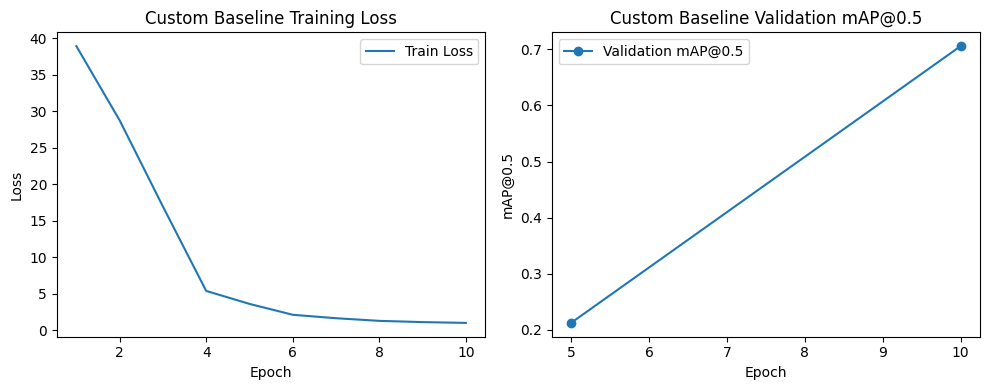

In [31]:
# Plot loss and mAP curve for custom baseline
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS_CUSTOM_BASE + 1), train_losses_custom_base, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Custom Baseline Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
# Need to map the epochs where validation was performed to the list indices
eval_epochs = [(i + 1) for i in range(EPOCHS_CUSTOM_BASE) if (i + 1) % 5 == 0 or i == EPOCHS_CUSTOM_BASE - 1]
plt.plot(eval_epochs, val_maps_custom_base, marker='o', label='Validation mAP@0.5')
plt.xlabel('Epoch')
plt.ylabel('mAP@0.5')
plt.title('Custom Baseline Validation mAP@0.5')
plt.legend()

plt.tight_layout()
plt.show()


Visualizing a few custom baseline predictions:
Image 0
  Predicted: Conf=0.99, Class=circle, Score=0.98, Box=[0.6048693656921387, 0.6902494430541992, 0.15393733978271484, 0.16394378244876862]
  Ground Truth: Class=circle, Box=[0.5976560115814209, 0.6445310115814209, 0.2070309966802597, 0.2070309966802597]


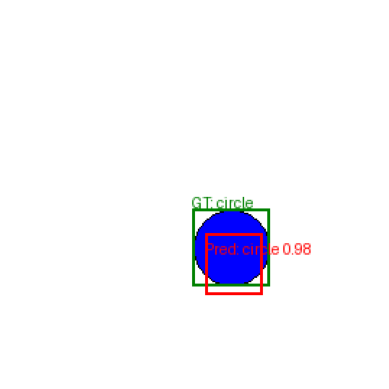

Image 1
  Predicted: Conf=0.99, Class=circle, Score=0.98, Box=[0.26119035482406616, 0.3595304787158966, 0.1725129783153534, 0.18869639933109283]
  Ground Truth: Class=circle, Box=[0.2773439884185791, 0.3554689884185791, 0.2109380066394806, 0.2109380066394806]


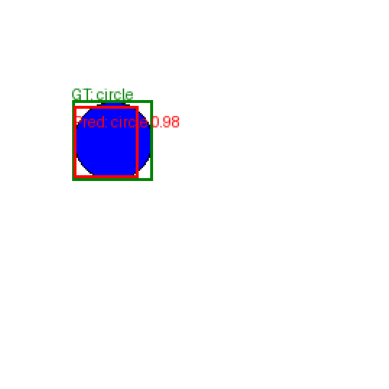

Image 2
  Predicted: Conf=1.00, Class=square, Score=0.99, Box=[0.8404850363731384, 0.30160197615623474, 0.09436290711164474, 0.09499603509902954]
  Ground Truth: Class=square, Box=[0.875, 0.2773439884185791, 0.125, 0.125]


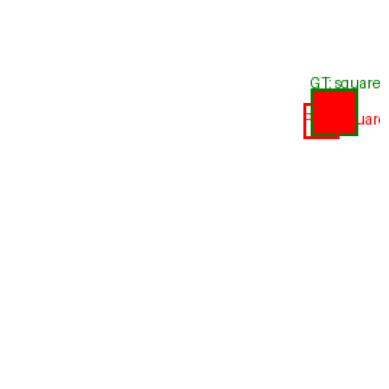

In [32]:
# Visualize a few predictions from the custom baseline model
print("\nVisualizing a few custom baseline predictions:")
custom_model_base.eval()

visualize_count = 3

with torch.no_grad():
    for i in range(min(visualize_count, len(custom_val_dataset))): # Visualize first 5 images
        img_tensor, target_tensor = custom_val_dataset[i]
        img_tensor = img_tensor.unsqueeze(0).to(device) # Add batch dimension and move to device

        prediction = custom_model_base(img_tensor).squeeze(0) # Get prediction for one image

        # Convert single prediction tensor to list format expected by plot_image_with_boxes
        # [conf, xc, yc, w, h, class_prob_0, class_prob_1, ...]
        conf = prediction[0].item()
        box_coords = prediction[1:5].cpu().tolist() # [xc, yc, w, h]
        class_probs = prediction[5:]
        class_score, class_pred_idx = torch.max(class_probs, dim=0)
        class_pred_idx = class_pred_idx.item()
        prob_score = conf * class_score.item()

        # Format for plotting: [class_pred, prob_score, x, y, w, h]
        predicted_box_for_plot = []
        if conf > 0.5: # Only plot if confidence is above a threshold
             predicted_box_for_plot = [[class_pred_idx, prob_score] + box_coords]

        # Also get true box for comparison
        true_box_for_plot = []
        if target_tensor[0] > 0.5:
             true_class_idx = torch.argmax(target_tensor[5:]).item()
             true_box_coords = target_tensor[1:5].cpu().tolist()
             true_box_for_plot = [[true_class_idx, 1.0] + true_box_coords] # Using 1.0 score for ground truth


        print(f"Image {i}")
        print(f"  Predicted: Conf={conf:.2f}, Class={CLASSES[class_pred_idx]}, Score={prob_score:.2f}, Box={box_coords}")
        if true_box_for_plot:
            print(f"  Ground Truth: Class={CLASSES[true_box_for_plot[0][0]]}, Box={true_box_for_plot[0][2:]}")
        else:
            print("  Ground Truth: No object")


        # Plot both predicted and true boxes (using different colors/styles might be nice but simple version uses one color)
        # Let's plot GT in green and Pred in red (if confidence > threshold)
        temp_img = transforms.ToPILImage()(img_tensor.squeeze(0).cpu())
        temp_draw = ImageDraw.Draw(temp_img)

        img_w, img_h = temp_img.size

        # Draw ground truth box (green)
        for box in true_box_for_plot:
            cls_id, score, xc, yc, w, h = box
            x1 = int((xc - w/2) * img_w)
            y1 = int((yc - h/2) * img_h)
            x2 = int((xc + w/2) * img_w)
            y2 = int((yc + h/2) * img_h)
            temp_draw.rectangle([(x1, y1), (x2, y2)], outline='green', width=2)
            try:
                temp_draw.text((x1, y1-10), f'GT: {CLASSES[cls_id]}', fill='green')
            except: pass

        # Draw predicted box (red) if confidence > threshold
        for box in predicted_box_for_plot:
            cls_id, score, xc, yc, w, h = box
            x1 = int((xc - w/2) * img_w)
            y1 = int((yc - h/2) * img_h)
            x2 = int((xc + w/2) * img_w)
            y2 = int((yc + h/2) * img_h)
            temp_draw.rectangle([(x1, y1), (x2, y2)], outline='red', width=2)
            try:
                temp_draw.text((x1, y1+5), f'Pred: {CLASSES[cls_id]} {score:.2f}', fill='red')
            except: pass

        plt.imshow(temp_img)
        plt.axis('off')
        plt.show()



### 4.d Сравнение результатов с базовой моделью (Ultralytics)

Сравним mAP@0.5 имплементированной простой модели детекции с mAP@0.5 базовой модели Ultralytics YOLOv8n, обученной на многообъектном датасете.

In [33]:
print(f"Ultralytics YOLOv8n (Baseline) mAP@0.5: {mAP50_base:.4f}")
print(f"Custom Simple Detector (Baseline) mAP@0.5: {mAP_50_final_custom_base.item():.4f}")

Ultralytics YOLOv8n (Baseline) mAP@0.5: 0.9849
Custom Simple Detector (Baseline) mAP@0.5: 0.7059


| Metric  | YOLO (Baseline) | Custom Simple Detector (Baseline) |
|---------|:-----------------:|:---------------------------------:|
| mAP@0.5 |       0.9849          |       0.7059          |

### 4.e Выводы по имплементации

Имплементированная простая модель детекции, обученная на датасете с одним объектом, ожидаемо показывает значительно более низкий mAP@0.5 (0.7059) по сравнению с готовой, полнофункциональной моделью Ultralytics YOLOv8n (0.9849), обученной на датасете с несколькими объектами. Это связано с кардинально разной сложностью моделей и задач: YOLOv8n спроектирована для сложных сценариев с множеством объектов в разных масштабах, тогда как имплементация - это упрощенная модель, способная найти лишь один доминирующий объект. Тем не менее, имплементация демонстрирует базовую структуру и компоненты модели детекции (CNN для признаков, полносвязные слои для предсказаний, функция потерь для координат, уверенности и классов).

### 4.f Добавление техник из улучшенного бейзлайна

Из техник улучшенного бейзлайна Ultralytics, наиболее применимыми к простой модели являются: **увеличение количества эпох обучения** и **настройка скорости обучения (LR)**.

In [34]:
# Re-instantiate the custom model (or load state dict if continuing from previous training)
custom_model_improved = SimpleDetectorCNN(in_channels=3, num_classes=NUM_CLASSES, img_size=IMAGE_SIZE).to(device)
# Optionally load the state dict from the base training to continue training
# custom_model_improved.load_state_dict(torch.load('simple_detector_base.pth'))

custom_loss_fn_improved = SimpleDetectionLoss()

# Apply improved training parameters
LR_CUSTOM_IMPROVED = 0.0005 # Try a lower LR for longer training
EPOCHS_CUSTOM_IMPROVED = 20 # Increased epochs

custom_optimizer_improved = optim.Adam(custom_model_improved.parameters(), lr=LR_CUSTOM_IMPROVED)




Calculated flattened size: 32768


### 4.g Обучение модели с улучшенными техниками

In [35]:
train_losses_custom_improved = []
val_maps_custom_improved = []

for epoch in range(EPOCHS_CUSTOM_IMPROVED):
    print(f"\nEpoch {epoch+1}/{EPOCHS_CUSTOM_IMPROVED}")
    train_loss = train_simple_detector(custom_train_loader, custom_model_improved, custom_optimizer_improved, custom_loss_fn_improved, device)
    train_losses_custom_improved.append(train_loss)

    # Evaluate mAP on validation set after some epochs
    if (epoch + 1) % 5 == 0 or epoch == EPOCHS_CUSTOM_IMPROVED - 1:
        mAP_50, _, _ = evaluate_simple_detector_map(custom_val_loader, custom_model_improved, iou_threshold=0.5, conf_threshold=0.5, device=device, num_classes=NUM_CLASSES, box_format="midpoint")
        val_maps_custom_improved.append(mAP_50.item())
        print(f"Validation mAP@0.5: {mAP_50.item():.4f}")

print("Finished Custom Improved Training")


Epoch 1/20


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 36.6097

Epoch 2/20


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 26.0497

Epoch 3/20


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 13.3518

Epoch 4/20


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 4.6263

Epoch 5/20


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 2.9168


Evaluating Custom Model:   0%|          | 0/4 [00:00<?, ?it/s]

Validation mAP@0.5: 0.3204

Epoch 6/20


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 2.2421

Epoch 7/20


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 1.8632

Epoch 8/20


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 1.7299

Epoch 9/20


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 1.4994

Epoch 10/20


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 1.3171


Evaluating Custom Model:   0%|          | 0/4 [00:00<?, ?it/s]

Validation mAP@0.5: 0.7850

Epoch 11/20


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 1.1618

Epoch 12/20


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 1.0953

Epoch 13/20


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 1.0022

Epoch 14/20


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 0.9692

Epoch 15/20


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 1.0081


Evaluating Custom Model:   0%|          | 0/4 [00:00<?, ?it/s]

Validation mAP@0.5: 0.6449

Epoch 16/20


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 1.0365

Epoch 17/20


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 0.9551

Epoch 18/20


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 1.0824

Epoch 19/20


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 0.8166

Epoch 20/20


Training Batch:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch average loss: 0.7852


Evaluating Custom Model:   0%|          | 0/4 [00:00<?, ?it/s]

Validation mAP@0.5: 0.8867
Finished Custom Improved Training


In [36]:
# Save the state dict of the custom improved model
torch.save(custom_model_improved.state_dict(), 'simple_detector_improved.pth')
print("Saved custom improved model state dict.")

Saved custom improved model state dict.


### 4.h Оценка качества модели

In [37]:
# Final evaluation of the custom improved model
mAP_50_final_custom_improved, pred_boxes_custom_improved, true_boxes_custom_improved = evaluate_simple_detector_map(
    custom_val_loader, custom_model_improved, iou_threshold=0.5, conf_threshold=0.5, device=device, num_classes=NUM_CLASSES, box_format="midpoint"
)

print(f"Custom Improved Simple Detector Final mAP@0.5: {mAP_50_final_custom_improved.item():.4f}")

Evaluating Custom Model:   0%|          | 0/4 [00:00<?, ?it/s]

Custom Improved Simple Detector Final mAP@0.5: 0.8867


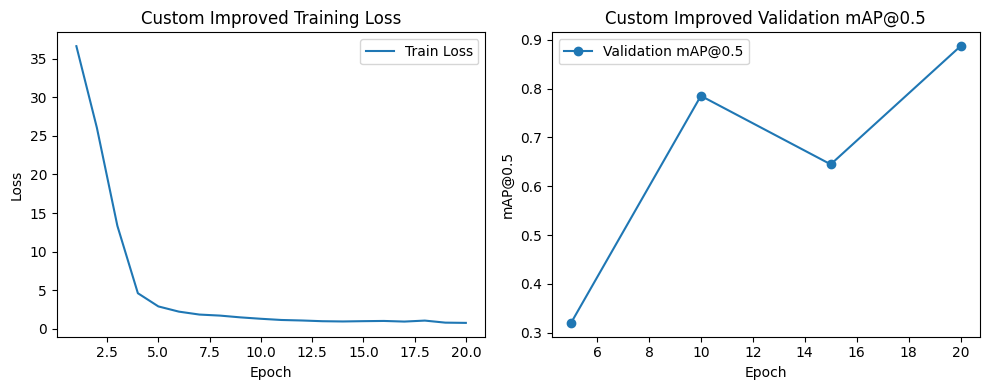

In [38]:
# Plot loss and mAP curve for custom improved
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS_CUSTOM_IMPROVED + 1), train_losses_custom_improved, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Custom Improved Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
eval_epochs_improved = [(i + 1) for i in range(EPOCHS_CUSTOM_IMPROVED) if (i + 1) % 5 == 0 or i == EPOCHS_CUSTOM_IMPROVED - 1]
plt.plot(eval_epochs_improved, val_maps_custom_improved, marker='o', label='Validation mAP@0.5')
plt.xlabel('Epoch')
plt.ylabel('mAP@0.5')
plt.title('Custom Improved Validation mAP@0.5')
plt.legend()

plt.tight_layout()
plt.show()


Visualizing a few custom improved predictions:
Image 0
  Predicted: Conf=0.99, Class=circle, Score=0.99, Box=[0.5935284495353699, 0.6459730267524719, 0.19337758421897888, 0.19462883472442627]
  Ground Truth: Class=circle, Box=[0.5976560115814209, 0.6445310115814209, 0.2070309966802597, 0.2070309966802597]


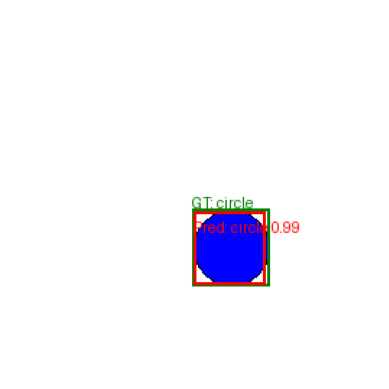

Image 1
  Predicted: Conf=0.99, Class=circle, Score=0.99, Box=[0.27446332573890686, 0.3590964078903198, 0.19695614278316498, 0.19110830128192902]
  Ground Truth: Class=circle, Box=[0.2773439884185791, 0.3554689884185791, 0.2109380066394806, 0.2109380066394806]


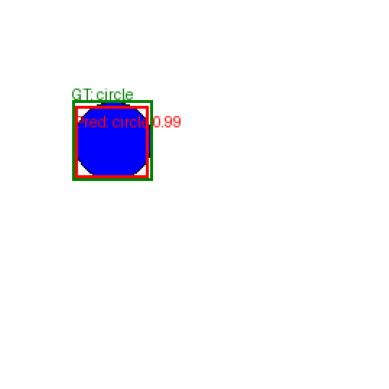

Image 2
  Predicted: Conf=1.00, Class=square, Score=0.97, Box=[0.8225112557411194, 0.3322547972202301, 0.10408596694469452, 0.10284999758005142]
  Ground Truth: Class=square, Box=[0.875, 0.2773439884185791, 0.125, 0.125]


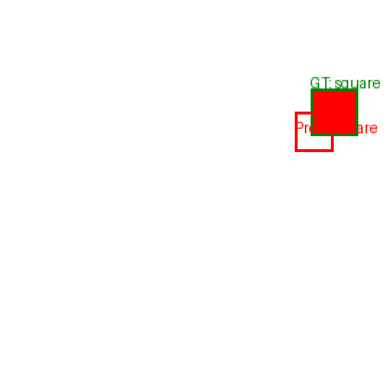

In [39]:
# Visualize a few predictions from the custom improved model
print("\nVisualizing a few custom improved predictions:")
custom_model_improved.eval()

visualize_count = 3

with torch.no_grad():
    for i in range(min(visualize_count, len(custom_val_dataset))): # Visualize first 5 images
        img_tensor, target_tensor = custom_val_dataset[i]
        img_tensor = img_tensor.unsqueeze(0).to(device) # Add batch dimension and move to device

        prediction = custom_model_improved(img_tensor).squeeze(0) # Get prediction for one image

        conf = prediction[0].item()
        box_coords = prediction[1:5].cpu().tolist() # [xc, yc, w, h]
        class_probs = prediction[5:]
        class_score, class_pred_idx = torch.max(class_probs, dim=0)
        class_pred_idx = class_pred_idx.item()
        prob_score = conf * class_score.item()

        predicted_box_for_plot = []
        if conf > 0.5: # Only plot if confidence is above a threshold
             predicted_box_for_plot = [[class_pred_idx, prob_score] + box_coords]

        true_box_for_plot = []
        if target_tensor[0] > 0.5:
             true_class_idx = torch.argmax(target_tensor[5:]).item()
             true_box_coords = target_tensor[1:5].cpu().tolist()
             true_box_for_plot = [[true_class_idx, 1.0] + true_box_coords]


        print(f"Image {i}")
        print(f"  Predicted: Conf={conf:.2f}, Class={CLASSES[class_pred_idx]}, Score={prob_score:.2f}, Box={box_coords}")
        if true_box_for_plot:
            print(f"  Ground Truth: Class={CLASSES[true_box_for_plot[0][0]]}, Box={true_box_for_plot[0][2:]}")
        else:
            print("  Ground Truth: No object")

        temp_img = transforms.ToPILImage()(img_tensor.squeeze(0).cpu())
        temp_draw = ImageDraw.Draw(temp_img)
        img_w, img_h = temp_img.size

        for box in true_box_for_plot:
            cls_id, score, xc, yc, w, h = box
            x1 = int((xc - w/2) * img_w)
            y1 = int((yc - h/2) * img_h)
            x2 = int((xc + w/2) * img_w)
            y2 = int((yc + h/2) * img_h)
            temp_draw.rectangle([(x1, y1), (x2, y2)], outline='green', width=2)
            try:
                temp_draw.text((x1, y1-10), f'GT: {CLASSES[cls_id]}', fill='green')
            except: pass

        for box in predicted_box_for_plot:
            cls_id, score, xc, yc, w, h = box
            x1 = int((xc - w/2) * img_w)
            y1 = int((yc - h/2) * img_h)
            x2 = int((xc + w/2) * img_w)
            y2 = int((yc + h/2) * img_h)
            temp_draw.rectangle([(x1, y1), (x2, y2)], outline='red', width=2)
            try:
                temp_draw.text((x1, y1+5), f'Pred: {CLASSES[cls_id]} {score:.2f}', fill='red')
            except: pass

        plt.imshow(temp_img)
        plt.axis('off')
        plt.show()




### 4.i Сравнение результатов с улучшенным бейзлайном (Ultralytics)

Сравним mAP@0.5 имплементированной простой модели с примененными техниками улучшения с mAP@0.5 улучшенной модели Ultralytics YOLOv8n.

In [40]:
print(f"Ultralytics YOLOv8n (Improved) mAP@0.5: {mAP50_improved:.4f}")
print(f"Custom Simple Detector (Improved) mAP@0.5: {mAP_50_final_custom_improved.item():.4f}")

Ultralytics YOLOv8n (Improved) mAP@0.5: 0.9874
Custom Simple Detector (Improved) mAP@0.5: 0.8867


| Metric  | YOLO (Improved) | Custom Simple Detector (Improved) |
|---------|:-----------------:|:---------------------------------:|
| mAP@0.5 |       0.9874          |       0.8867          |


### 4.j Выводы по сравнению с улучшенным бейзлайном

Даже после применения техник улучшения (увеличение эпох, настройка LR), имплементированная простая модель (mAP@0.5 0.8867) значительно уступает улучшенной модели Ultralytics YOLOv8n (mAP@0.5 0.9874). Это подчеркивает разницу в сложности архитектур и задачах, на которых они были обучены. YOLOv8n - это SOTA модель, оптимизированная для общей задачи детекции множества объектов на сложных изображениях, тогда как простая имплементация - это учебный пример, способный лишь на простейшую детекцию одного объекта. Однако, примененные техники (больше эпох, тонкая настройка LR) *улучшили* качество самой простой имплементации по сравнению с ее базовой версией (mAP@0.5 0.7059), что видно по графику mAP для кастомной модели. Это демонстрирует важность этих техник даже для простых моделей.